In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import os
from PIL import Image
import kaggle
from sklearn.model_selection import train_test_split
import pickle # to save training history

In [4]:
data_dir = './human-face-emotions/data'

In [ ]:
full_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    label_mode="int",
    image_size=(48, 48),
    color_mode="grayscale",
    batch_size=None,
    shuffle=True,
    seed=42
)

class_names = full_ds.class_names
num_classes = len(class_names)

print("Classes:", class_names)

Found 57756 files belonging to 5 classes.
Classes: ['Angry', 'Fear', 'Happy', 'Sad', 'Suprise']


In [7]:
full_data = list(full_ds.as_numpy_iterator())

images = [x[0] for x in full_data]  # list of arrays
labels = [x[1] for x in full_data]  # list of ints

In [ ]:
x_train, x_temp, y_train, y_temp = train_test_split(
    images, labels,
    test_size=0.30,         # 30% val+test
    random_state=42,
    stratify=labels 
)

x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp,
    test_size=0.50,         # 15% val, 15% test
    random_state=42,
    stratify=y_temp
)

In [9]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_ds   = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_ds  = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [10]:
batch_size = 128

train_ds = train_ds.shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [13]:
# early stopping to prevent overfitting
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(48, 48, 1)),
    #data_augmentation,

    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(48, 48, 1)),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# 32: number of filters -> 32 different pattern detectors
# (3×3) = kernel (=filter) size in pixels - like a (3×3) window
# padding='same' : 48×48 input → 48×48 output
# MaxPooling : reduces image size by taking the maximum value in each 3x3 window
# e.g. pooling keeps the strongest signals

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,269 (2.61 MB)

 Trainable params: 683,269 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history_1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[callback]
)

Epoch 1/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 18s 54ms/step - accuracy: 0.3188 - loss: 6.2674 - val_accuracy: 0.4545 - val_loss: 1.3268
Epoch 2/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 17s 53ms/step - accuracy: 0.4548 - loss: 1.3173 - val_accuracy: 0.4990 - val_loss: 1.2131
Epoch 3/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 17s 54ms/step - accuracy: 0.5062 - loss: 1.2042 - val_accuracy: 0.5294 - val_loss: 1.1466
Epoch 4/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 22s 69ms/step - accuracy: 0.5416 - loss: 1.1212 - val_accuracy: 0.5660 - val_loss: 1.0753
Epoch 5/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 22s 69ms/step - accuracy: 0.5868 - loss: 1.0212 - val_accuracy: 0.6031 - val_loss: 0.9976
Epoch 6/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 22s 68ms/step - accuracy: 0.6256 - loss: 0.9368 - val_accuracy: 0.6282 - val_loss: 0.9485
Epoch 7/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - accuracy: 0.6666 - loss: 0.8490 - val_accuracy: 0.6560 - val_loss: 0.8913
Epoch 8/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 21s 65ms/step - accuracy: 0.6951 - loss: 0.7787 - 

In [18]:
test_loss, test_acc = model.evaluate(test_ds)
print("Final Test Accuracy:", test_acc)

68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8081 - loss: 0.6852
Final Test Accuracy: 0.8027470111846924


In [ ]:
model.save('models/cnn_og.keras')

In [ ]:
with open("training_history/history_cnn_og.pkl", "wb") as f:
    pickle.dump(history_1.history, f)

## OG but 2 conv layers

In [ ]:
model_2conv = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(48, 48, 1)),
    #data_augmentation,

    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(48, 48, 1)),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model_2conv.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_2conv.summary()

c:\Users\sandralm\AppData\Local\miniconda3\envs\IDS\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       589,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 609,029 (2.32 MB)

 Trainable params: 609,029 (2.32 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
history_2conv = model_2conv.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[callback]
)

Epoch 1/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 26s 76ms/step - accuracy: 0.2881 - loss: 9.9959 - val_accuracy: 0.4030 - val_loss: 1.4342
Epoch 2/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 34s 106ms/step - accuracy: 0.3910 - loss: 1.4231 - val_accuracy: 0.4616 - val_loss: 1.2967
Epoch 3/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 41s 106ms/step - accuracy: 0.4463 - loss: 1.3206 - val_accuracy: 0.4977 - val_loss: 1.2238
Epoch 4/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 33s 104ms/step - accuracy: 0.4776 - loss: 1.2489 - val_accuracy: 0.5242 - val_loss: 1.1789
Epoch 5/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 32s 102ms/step - accuracy: 0.5030 - loss: 1.1943 - val_accuracy: 0.5489 - val_loss: 1.1205
Epoch 6/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 37s 116ms/step - accuracy: 0.5316 - loss: 1.1282 - val_accuracy: 0.5550 - val_loss: 1.1212
Epoch 7/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 28s 90ms/step - accuracy: 0.5544 - loss: 1.0795 - val_accuracy: 0.5702 - val_loss: 1.0834
Epoch 8/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 30s 94ms/step - accuracy: 0.5767 - loss: 1.02

### visualisation of OG

In [71]:
class_names = ["Angry", "Fear", "Happy", "Sad", "Surprise"]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Classes: ['angry', 'fear', 'happy', 'sad', 'surprise']


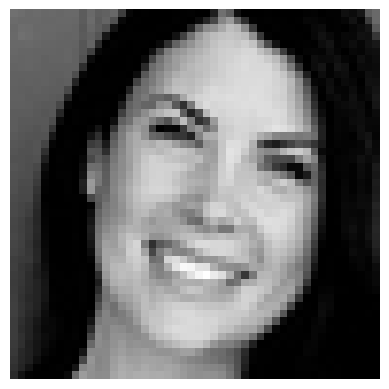

Predicted class: 2 (happy)
Actual class:     2 (happy)
----------------------------------------


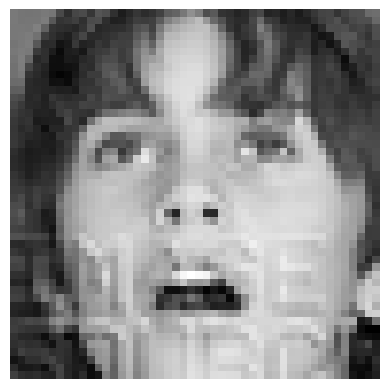

Predicted class: 4 (surprise)
Actual class:     4 (surprise)
----------------------------------------


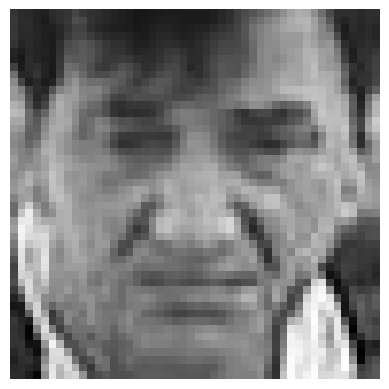

Predicted class: 3 (sad)
Actual class:     3 (sad)
----------------------------------------


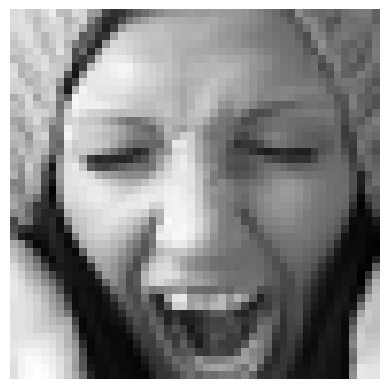

Predicted class: 1 (fear)
Actual class:     1 (fear)
----------------------------------------


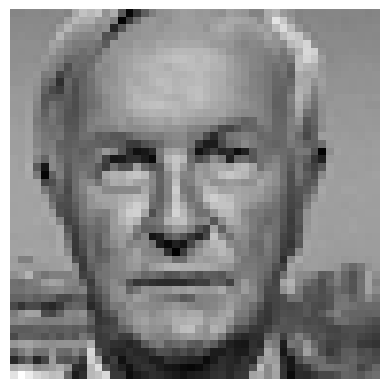

Predicted class: 0 (angry)
Actual class:     0 (angry)
----------------------------------------


In [ ]:
images, labels = next(iter(test_ds))
n_images = 5
predictions = model.predict(images[:n_images])
print("Classes:", class_names)

for i in range(n_images):
    img = images[i].numpy()
    label = labels[i].numpy()

    # (48,48,1) to (48,48) for grayscale display
    if img.shape[-1] == 1:
        img = img.reshape(48, 48)

    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.show()

    predicted = np.argmax(predictions[i])

    print(f"Predicted class: {predicted} ({class_names[predicted]})")
    print(f"Actual class:     {label} ({class_names[label]})")
    print("-" * 40)

In [29]:
shuffled = test_ds.shuffle(5000)
images_shuffled, labels_shuffled = next(iter(shuffled))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


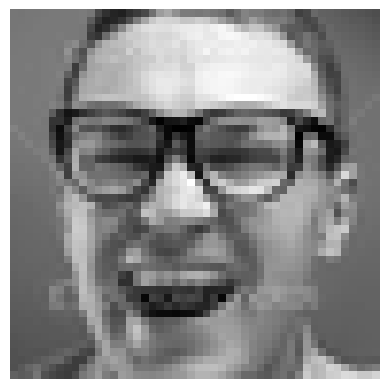

Predicted: happy
Actual:    happy
----------------------------------------


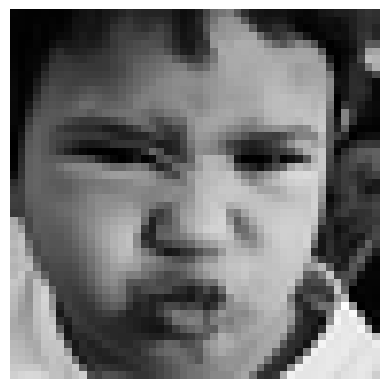

Predicted: angry
Actual:    angry
----------------------------------------


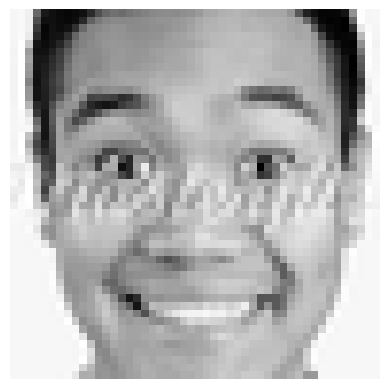

Predicted: happy
Actual:    happy
----------------------------------------


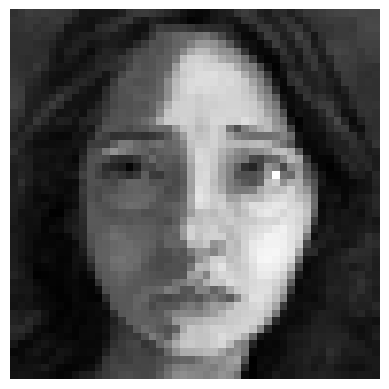

Predicted: sad
Actual:    sad
----------------------------------------


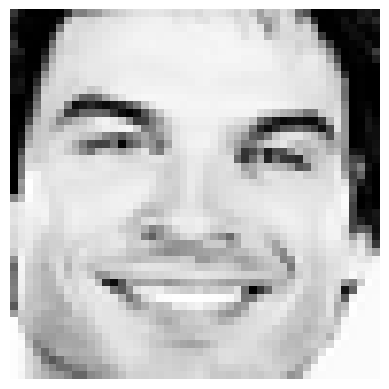

Predicted: happy
Actual:    happy
----------------------------------------


In [ ]:
predictions = model.predict(images_shuffled[:n_images])

for i in range(n_images):
    img = images_shuffled[i].numpy()
    label = labels_shuffled[i].numpy()

    if img.shape[-1] == 1:
        img = img.reshape(48,48)

    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.show()

    predicted = np.argmax(predictions[i])
    print(f"Predicted: {class_names[predicted]}")
    print(f"Actual:    {class_names[label]}")
    print("-" * 40)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


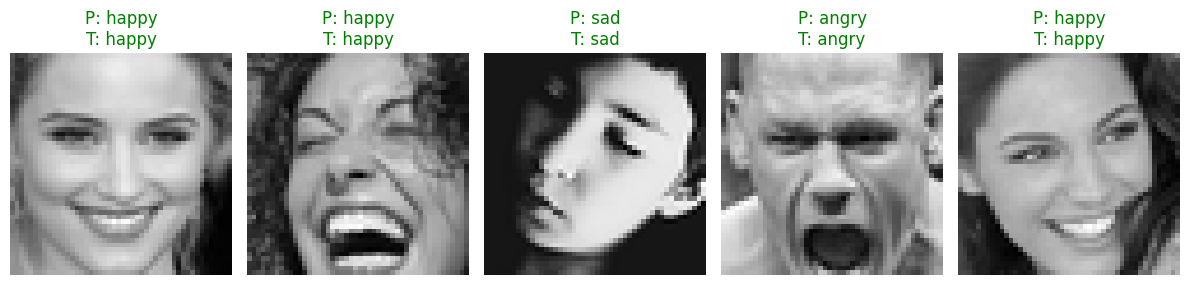

In [ ]:

shuffled = test_ds.shuffle(5000)
images, labels = next(iter(shuffled))
images = images[:n_images]
labels = labels[:n_images]

preds = model.predict(images)
pred_classes = np.argmax(preds, axis=1)

plt.figure(figsize=(12, 4))

for i in range(n_images):
    plt.subplot(1, n_images, i+1)

    img = images[i].numpy()
    if img.shape[-1] == 1:
        img = img.reshape(48, 48)

    plt.imshow(img, cmap="gray")
    plt.axis("off")

    true_label = class_names[labels[i]]
    pred_label = class_names[pred_classes[i]]

    color = "green" if true_label == pred_label else "red"
    plt.title(f"P: {pred_label}\nT: {true_label}", color=color)

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


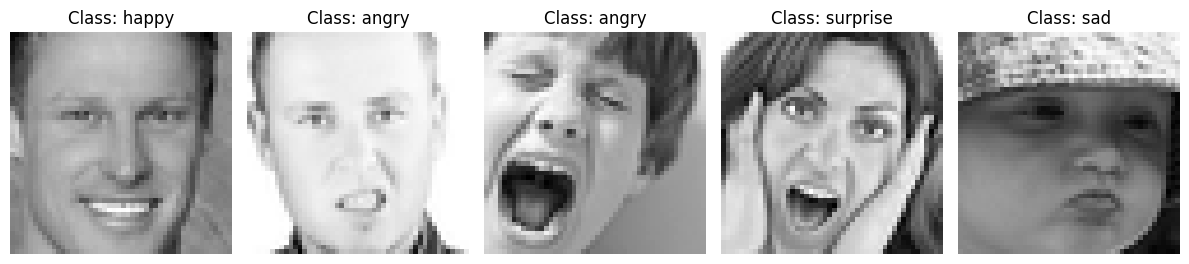

In [ ]:
images = images[:n_images]
labels = labels[:n_images]

preds = model.predict(images)
pred_classes = np.argmax(preds, axis=1)

plt.figure(figsize=(12, 4))

for i in range(n_images):
    plt.subplot(1, n_images, i+1)

    img = images[i].numpy()
    if img.shape[-1] == 1:
        img = img.reshape(48, 48)

    plt.imshow(img, cmap="gray")
    plt.axis("off")

    true_label = class_names[labels[i]]
    pred_label = class_names[pred_classes[i]]

    color = "Black" if true_label == pred_label else "red"
    plt.title(f"Class: {true_label}", color=color)

plt.tight_layout()
#plt.savefig("example_images.png")
plt.show()

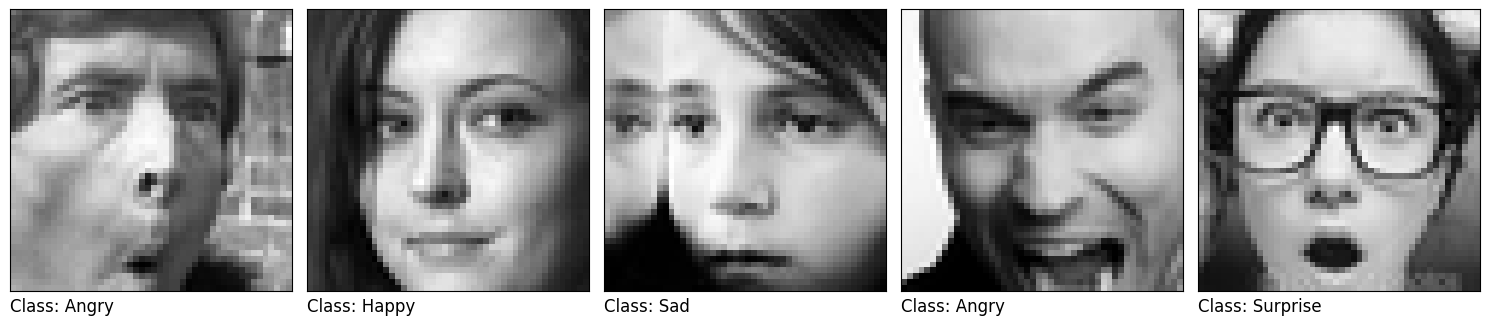

In [ ]:
shuffled = test_ds.shuffle(5000)
images, labels = next(iter(shuffled))

n_images = 5
plt.figure(figsize=(15, 6))

for i in range(n_images):
    ax = plt.subplot(1, n_images, i+1)

    img = images[i].numpy().squeeze()
    ax.imshow(img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

    predicted = class_names[preds[i]]
    actual = class_names[labels[i]]

    ax.set_xlabel(f"Class: {actual}",
                  fontsize=12, loc='left')

plt.tight_layout()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━

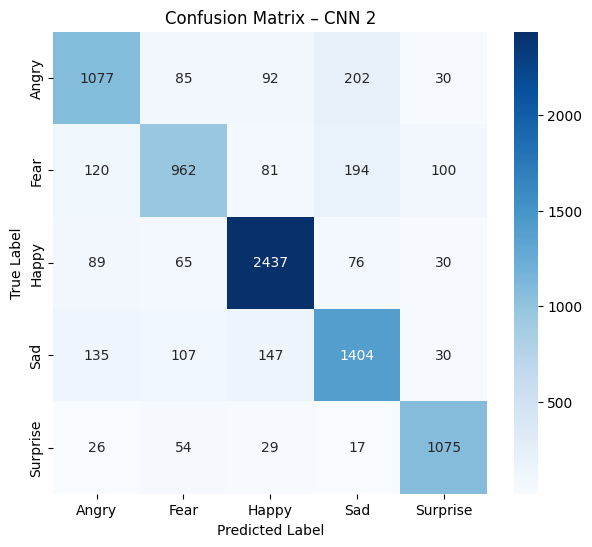

In [ ]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    preds = np.argmax(preds, axis=1)
    
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – CNN 2")
#plt.savefig("og_cnn_confusion_matrix.png")
plt.show()

In [ ]:
confusions = []

for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j:
            confusions.append((cm[i][j], class_names[i], class_names[j]))

confusions_sorted = sorted(confusions, reverse=True)

print("Top confusion pairs:")
for count, true_label, pred_label in confusions_sorted[:30]:
    print(f"{true_label} → {pred_label}: {count}")

Top confusion pairs:
angry → sad: 202
fear → sad: 194
sad → happy: 147
sad → angry: 135
fear → angry: 120
sad → fear: 107
fear → surprise: 100
angry → happy: 92
happy → angry: 89
angry → fear: 85
fear → happy: 81
happy → sad: 76
happy → fear: 65
surprise → fear: 54
sad → surprise: 30
happy → surprise: 30
angry → surprise: 30
surprise → happy: 29
surprise → angry: 26
surprise → sad: 17


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

       angry       0.74      0.72      0.73      1486
        fear       0.76      0.66      0.70      1457
       happy       0.87      0.90      0.89      2697
         sad       0.74      0.77      0.76      1823
    surprise       0.85      0.90      0.87      1201

    accuracy                           0.80      8664
   macro avg       0.79      0.79      0.79      8664
weighted avg       0.80      0.80      0.80      8664



In [ ]:
classes = ["Angry", "Fear", "Happy", "Sad", "Surprise"]
f1_scores_cnn_og = [0.73, 0.70, 0.89, 0.76, 0.87]
f1_scores_mobilenet = [0.79, 0.72, 0.87, 0.76, 0.83]

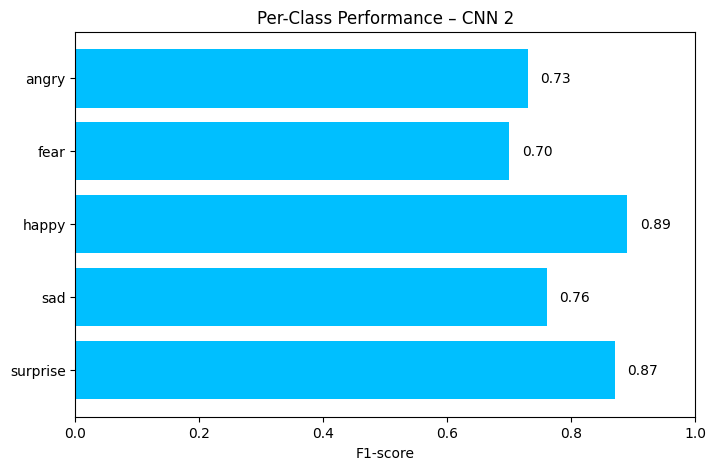

In [73]:
plt.figure(figsize=(8,5))
plt.barh(classes, f1_scores, color="deepskyblue")

plt.xlim(0,1)
plt.xlabel("F1-score")
plt.title("Per-Class Performance")

for i, v in enumerate(f1_scores):
    plt.text(v + 0.02, i, f"{v:.2f}", va="center")

plt.gca().invert_yaxis()
#plt.savefig("og_cnn_f1.png")
plt.show()

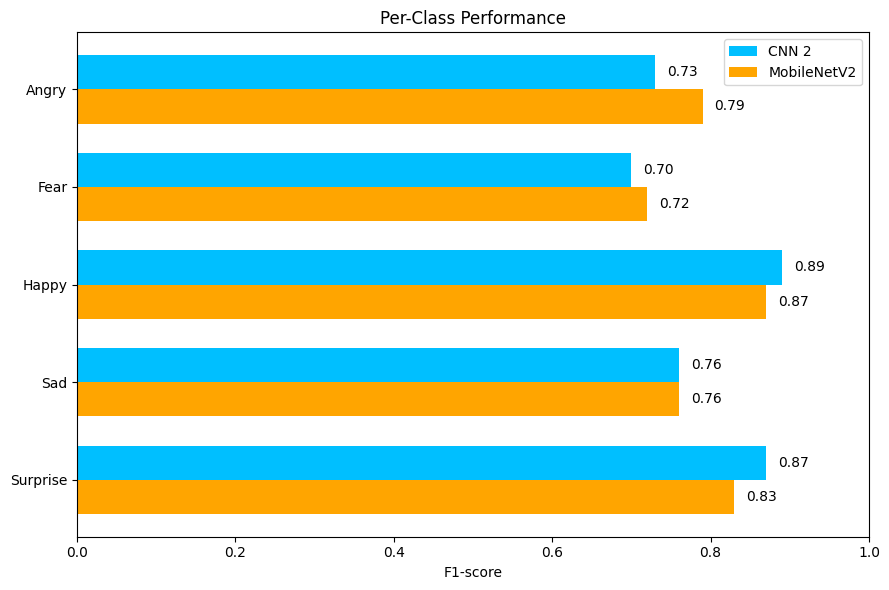

In [77]:
classes = ["Angry", "Fear", "Happy", "Sad", "Surprise"]
f1_scores_cnn_og = [0.73, 0.70, 0.89, 0.76, 0.87]
f1_scores_mobilenet = [0.79, 0.72, 0.87, 0.76, 0.83]

y = np.arange(len(classes))
height = 0.35

plt.figure(figsize=(9,6))

plt.barh(y - height/2, f1_scores_cnn_og, height,
         color="deepskyblue", label="CNN 2")

plt.barh(y + height/2, f1_scores_mobilenet, height,
         color="orange", label="MobileNetV2")

for i, v in enumerate(f1_scores_cnn_og):
    plt.text(v + 0.015, i - height/2, f"{v:.2f}", va="center")

for i, v in enumerate(f1_scores_mobilenet):
    plt.text(v + 0.015, i + height/2, f"{v:.2f}", va="center")

plt.yticks(y, classes)
plt.xlabel("F1-score")
plt.xlim(0, 1)
plt.title("Per-Class Performance")
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("f1_per_class.png")
plt.show()
